# Try to recover performance on unlearned task adversarially

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('acdcpp/Automatic-Circuit-Discovery/')
sys.path.append('acdcpp/')
from acdc import TLACDCExperiment
from acdcpp.ACDCPPExperiment import ACDCPPExperiment

import os
import sys
import re

# import acdc
from acdc.TLACDCExperiment import TLACDCExperiment
from acdc.acdc_utils import TorchIndex, EdgeType
import numpy as np
import torch as t
from torch import Tensor
import einops
import itertools

from transformer_lens import HookedTransformer, ActivationCache

from tqdm import tqdm
import plotly
from rich import print as rprint
from rich.table import Table

from jaxtyping import Float, Bool
from typing import Callable, Tuple, Union, Dict, Optional

import torch
import pickle

device = t.device('cuda') if t.cuda.is_available() else t.device('cpu')
print(f'Device: {device}')

Device: cuda


## First, load model back in

In [15]:
edge_masks = False
use_uniform = False
ioi_uniform_type = "IO_S"
weight_masks_attn = False
weight_masks_mlp = False
train_base_weights = False
localize_acdcpp = False

run_name = f"{use_uniform=}_"
if use_uniform:
    run_name += f"_{ioi_uniform_type=}_"
run_name += f"{edge_masks=}_{weight_masks_attn=}_{weight_masks_mlp=}_{train_base_weights=}_{localize_acdcpp=}"

epoch = 200
# want to open masks/{run_name}/mask_params_epoch=200.pt
mask_params_path = f'masks/{run_name}/mask_params_epoch={epoch}.pt'
mask_params = torch.load(mask_params_path, map_location=device)

In [16]:
from cb_utils.models import load_demo_gpt2, tokenizer
model = load_demo_gpt2(means=False, edge_masks=edge_masks, weight_masks_attn=weight_masks_attn, weight_masks_mlp=weight_masks_mlp, train_base_weights=train_base_weights)
from tasks import IOITask
task = IOITask(batch_size=16, tokenizer=tokenizer, device=device)
print(task.get_test_accuracy(model))

AttributeError: 'Attention' object has no attribute 'W_untrainable_Q_baseline'

### Load unlearned model

In [4]:
# load mask params into model
for k, v in model.named_parameters():
    if v.requires_grad:
        mask = mask_params.pop(0)
        v.data = mask

In [5]:
task = IOITask(batch_size=16, tokenizer=tokenizer, device=device)
print(task.get_test_accuracy(model))

0.4375


## Adversarial Retraining

In [ ]:
# try finetuning model (finetune only weights), for now only finetune the attention and mlps
from torch.optim import AdamW
from cb_utils.learn_mask import train_masks

for name, param in model.named_parameters():
    if "attn.W_Q" in name or "attn.W_K" in name or "attn.W_V" in name or "attn.W_O" in name or "mlp.W_in" in name or "mlp.W_out" in name:
        param.requires_grad = True
    elif "attn.b_Q" in name or "attn.b_K" in name or "attn.b_V" in name or "attn.b_O" in name or "mlp.b_in" in name or "mlp.b_out" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
# make param_names, mask_params
param_names = [n for n, p in model.named_parameters() if p.requires_grad]
mask_params = [p for n, p in model.named_parameters() if p.requires_grad]

lr = 1e-2
weight_decay = .1
optimizer = torch.optim.AdamW(mask_params, lr=lr, weight_decay=weight_decay)

In [ ]:
from tasks import IOITask, OWTTask
owt_task = OWTTask(batch_size=16, tokenizer=tokenizer, device=device)
# train_tasks = {"ioi": task, "owt": owt_task}
# task_weights = {"ioi": 1.0, "owt": 1.0}
train_tasks = {"ioi": task}
task_weights = {"ioi": 1.0}
# eval_tasks = {"ioi": task}
eval_tasks = {"ioi": task, "owt": owt_task}
train_losses, test_losses = train_masks(
    model,
    optimizer=optimizer,
    tasks=train_tasks,
    task_weights=task_weights,
    eval_tasks=eval_tasks,
    num_epochs=100,
    param_names=param_names,
    mask_params=mask_params,
    steps_per_epoch=10,
    evaluate_every=2,
    num_eval_steps=10,
    discretize_every=None,
    save_every=None,
)

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)
100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


In [ ]:
test_losses.keys()

dict_keys(['ioi', 'ioi_acc', 'owt', 'owt_acc'])

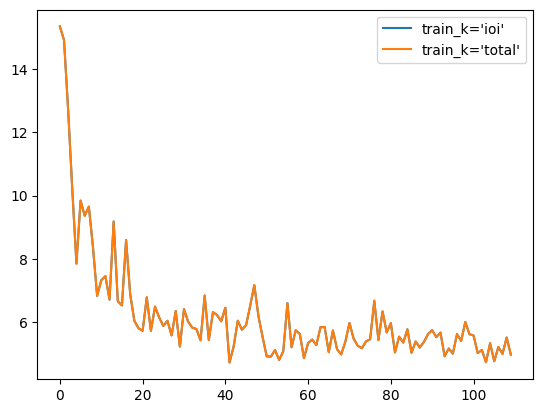

In [ ]:
# plot train_losses, test_losses
import matplotlib.pyplot as plt

for k, v in train_losses.items():
    plt.plot([x[2] for x in v], label=f"train_{k=}")
plt.legend()
plt.show()


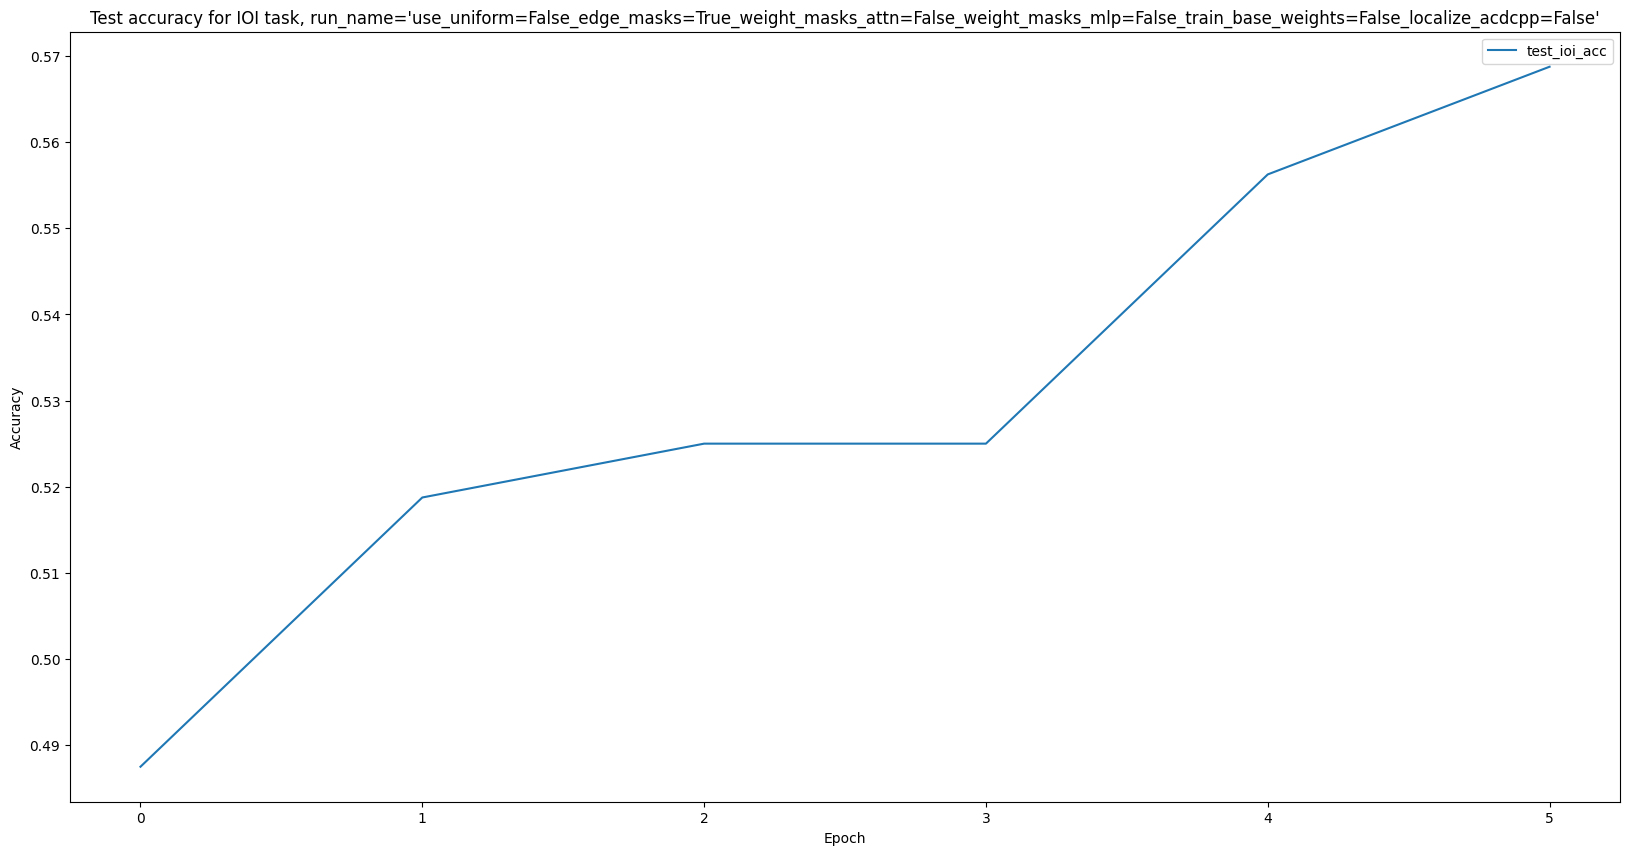

In [ ]:
# plt.plot([x.item() for x in test_losses["ioi"]], label="test_ioi_loss")
# plot make figure size
plt.figure(figsize=(20, 10))
plt.title(f"Test accuracy for IOI task, {run_name=}")
plt.plot([x for x in test_losses["ioi_acc"]], label="test_ioi_acc")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
model.blocks[8].edge_mask_attentions

Parameter containing:
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0', requires_grad=True)

In [ ]:
print((model.blocks[11].edge_mask_attentions == 0).sum())

tensor(0, device='cuda:0')


In [ ]:
model.blocks[11].edge_mask_attentions

Parameter containing:
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0')

In [ ]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

output_mask True
embed.W_E False
pos_embed.W_pos False
ln_final.w False
ln_final.b False
unembed.W_U False
unembed.b_U False
blocks.0.edge_mask_attentions True
blocks.0.edge_mask_mlp True
blocks.0.ln1.w False
blocks.0.ln1.b False
blocks.0.attn.W_Q False
blocks.0.attn.b_Q False
blocks.0.attn.W_K False
blocks.0.attn.b_K False
blocks.0.attn.W_V False
blocks.0.attn.b_V False
blocks.0.attn.W_O False
blocks.0.attn.b_O False
blocks.0.ln2.w False
blocks.0.ln2.b False
blocks.0.mlp.W_in False
blocks.0.mlp.b_in False
blocks.0.mlp.W_out False
blocks.0.mlp.b_out False
blocks.1.edge_mask_attentions True
blocks.1.edge_mask_mlp True
blocks.1.ln1.w False
blocks.1.ln1.b False
blocks.1.attn.W_Q False
blocks.1.attn.b_Q False
blocks.1.attn.W_K False
blocks.1.attn.b_K False
blocks.1.attn.W_V False
blocks.1.attn.b_V False
blocks.1.attn.W_O False
blocks.1.attn.b_O False
blocks.1.ln2.w False
blocks.1.ln2.b False
blocks.1.mlp.W_in False
blocks.1.mlp.b_in False
blocks.1.mlp.W_out False
blocks.1.mlp.b_out False
b

## Extraction Attacks
from https://arxiv.org/pdf/2309.17410.pdf

In [6]:
# logit lens: decode residual stream
from fancy_einsum import einsum

from collections import defaultdict
def layer_hook_function(layer, outputs):
    def hook_fn(module, input, output):
      outputs[layer].append(output.clone().detach())
      return output
    return hook_fn

def get_residuals(batch_text, model):
    outputs = defaultdict(list)
    hooks = []
    for layer, block in enumerate(model.blocks):
        hook_fn = layer_hook_function(layer, outputs=outputs)
        hook_applied = block.register_forward_hook(hook_fn)
        hooks.append(hook_applied)

    for prompt in batch_text:
        tokenized = tokenizer(prompt, return_tensors="pt").input_ids
        model(tokenized)
    
    for hook in hooks:
        hook.remove()
    
    return outputs

def get_logits(model, residual):
    num_components = residual.shape[-2]
    masked_resid = einsum("batch position prev_head_idx d_model, prev_head_idx -> batch position d_model", residual, model.output_mask[:num_components])
    normalized_resid = model.ln_final(masked_resid)
    logits = model.unembed(normalized_resid)
    return logits

In [7]:
task = IOITask(batch_size=64, tokenizer=tokenizer, device=device)
batch = task.get_batch()
outputs = get_residuals(batch['text'], model)

In [8]:
decode_layer = 9
logits = get_logits(model, outputs[decode_layer][0])[0, -1]
print(batch['text'][0])
print(f"Decoding at layer {decode_layer}, token: {logits.argmax(-1)}, name: {tokenizer.decode(logits.argmax(-1))}")

Then, Crew and Kate went to the store. Kate gave a drink to
Decoding at layer 9, token: 262, name:  the


In [9]:
import torch.nn.functional as F
import pandas as pd

n_layers = 12

# Initialize an empty DataFrame with MultiIndex
columns = pd.MultiIndex.from_product([range(n_layers), ['io_logprob', 's_logprob', 'io_pos']], names=['Layer', 'Metric'])
df = pd.DataFrame(columns=columns)

for point_idx in range(len(outputs[0])):
    io_token = tokenizer(" "+batch['IO'][point_idx])['input_ids'][-1]
    s_token = tokenizer(" "+batch['S'][point_idx])['input_ids'][-1]
    print(f"IO token: {io_token}, S token: {s_token}")
    data = {}  # This will hold the data for this point_idx
    for decode_layer in range(n_layers):
        with torch.no_grad():
            logits = get_logits(model, outputs[decode_layer][point_idx])[0, -1]
            logprobs = F.softmax(logits, dim=-1).log()
            io_logprob = logprobs[io_token].item()
            s_logprob = logprobs[s_token].item()
            io_s_logit_diff = (logits[io_token] - logits[s_token]).item()
            # Add the metrics to the data dictionary
            data[(decode_layer, 'io_logprob')] = io_logprob
            data[(decode_layer, 's_logprob')] = s_logprob
            
            # if io_logprob is the nth highest, store n
            io_pos = (logprobs >= io_logprob).sum().item()
            data[(decode_layer, 'io_pos')] = io_pos

    # Add the data for this point_idx to the DataFrame
    # df = df.append(pd.Series(data, name=point_idx))
    df.loc[point_idx] = pd.Series(data, name=point_idx)

# Now df holds the data for all point_idx and layers
display(df)

IO token: 17652, S token: 16693
IO token: 3899, S token: 11288
IO token: 12382, S token: 5866
IO token: 3271, S token: 14757
IO token: 8049, S token: 5278
IO token: 3362, S token: 16693
IO token: 8982, S token: 14909
IO token: 11336, S token: 10948
IO token: 12181, S token: 9308
IO token: 6858, S token: 17652
IO token: 3977, S token: 3362
IO token: 14316, S token: 8121
IO token: 17352, S token: 11328
IO token: 11288, S token: 6219
IO token: 10948, S token: 12246
IO token: 12091, S token: 7516
IO token: 5278, S token: 9918
IO token: 14200, S token: 6047
IO token: 7244, S token: 11526
IO token: 11465, S token: 10490
IO token: 11232, S token: 6858
IO token: 7993, S token: 9533
IO token: 20700, S token: 11325
IO token: 12313, S token: 5613
IO token: 10799, S token: 13307
IO token: 12091, S token: 14235
IO token: 8403, S token: 10674
IO token: 7970, S token: 10831
IO token: 10592, S token: 8239
IO token: 4302, S token: 12313
IO token: 14316, S token: 16738
IO token: 3362, S token: 3899
IO t

Layer          0                              1                       \
Metric io_logprob  s_logprob   io_pos io_logprob  s_logprob   io_pos   
0      -18.115656 -16.750559   8619.0 -22.982294 -20.936356  21806.0   
1      -16.004843 -16.623549   3964.0 -17.512341 -18.317144   4847.0   
2      -16.483570 -18.015982   4640.0 -19.579168 -21.176991  10117.0   
3      -13.054939 -18.803240   1173.0 -13.256538 -19.991503   1102.0   
4      -15.905428 -17.052341   3960.0 -20.043158 -18.098875  10712.0   
..            ...        ...      ...        ...        ...      ...   
59     -19.264881 -16.969187  13691.0 -20.330582 -18.823805  12514.0   
60     -20.218250 -16.497593  19088.0 -21.413223 -18.477154  17419.0   
61     -18.462940 -15.891951  10847.0 -18.995617 -17.509834   8600.0   
62     -18.146866 -16.835926   8725.0 -20.249666 -18.757145  11683.0   
63     -17.564987 -16.777624   6949.0 -20.247927 -18.817804  11143.0   

Layer          2                              3   ...       8          9   \
Metric io_logprob  s_logprob   io_pos io_logprob  ...   io_pos io_logprob   
0      -23.338064 -22.680891  13576.0 -22.845398  ...  15145.0 -19.634476   
1      -19.624826 -21.212503   5059.0 -17.155790  ...   8962.0 -14.169349   
2      -22.344587 -22.257790  10216.0 -21.919386  ...  11037.0 -15.725089   
3      -15.714427 -23.818434   1301.0 -14.349674  ...   4900.0 -16.929626   
4      -20.599371 -19.297155   6242.0 -20.219904  ...  10373.0 -14.892957   
..            ...        ...      ...        ...  ...      ...        ...   
59     -23.200626 -23.177094  12667.0 -21.533579  ...   4514.0 -14.577652   
60     -24.644018 -20.981127  18723.0 -23.439707  ...  13697.0 -19.257154   
61     -18.584276 -19.647364   3436.0 -16.478714  ...   4979.0 -12.786474   
62     -24.347111 -20.583046  17316.0 -23.749989  ...  39569.0 -22.761940   
63     -24.724762 -22.752506  17235.0 -24.920475  ...  16851.0 -18.241917   

Layer                              10                             11  \
Metric  s_logprob   io_pos io_logprob  s_logprob   io_pos io_logprob   
0      -16.250006  16136.0 -18.650126 -16.037741  14833.0 -19.559065   
1      -18.106106   3113.0 -14.347022 -18.336655   2975.0 -12.227976   
2      -16.373617   5086.0 -16.709572 -17.570278   7394.0 -16.295038   
3      -14.550849   6452.0 -14.311694 -15.811484   3400.0 -13.564656   
4      -16.517946   2150.0 -14.207630 -16.625935   2168.0 -13.748656   
..            ...      ...        ...        ...      ...        ...   
59     -17.638199   2783.0 -12.867270 -15.560931   1754.0 -11.716495   
60     -16.426065  14246.0 -18.438997 -16.339949  13585.0 -17.379166   
61     -14.517490   1399.0 -12.005032 -12.650780   1152.0 -13.564324   
62     -16.506748  32363.0 -21.123997 -17.289867  24335.0 -21.184189   
63     -21.166649  13475.0 -16.259264 -18.034941  13523.0 -13.439219   

Layer                       
Metric  s_logprob   io_pos  
0      -16.751226  26761.0  
1      -16.429415   1519.0  
2      -14.627810   9522.0  
3      -17.101856   2584.0  
4      -14.699149   3111.0  
..            ...      ...  
59     -14.016383   1109.0  
60     -15.045480  13243.0  
61     -11.472726   2991.0  
62     -16.690727  34882.0  
63     -15.895662   4671.0  

[64 rows x 36 columns]

### Attack 1: plot ave prob of IO token against layer

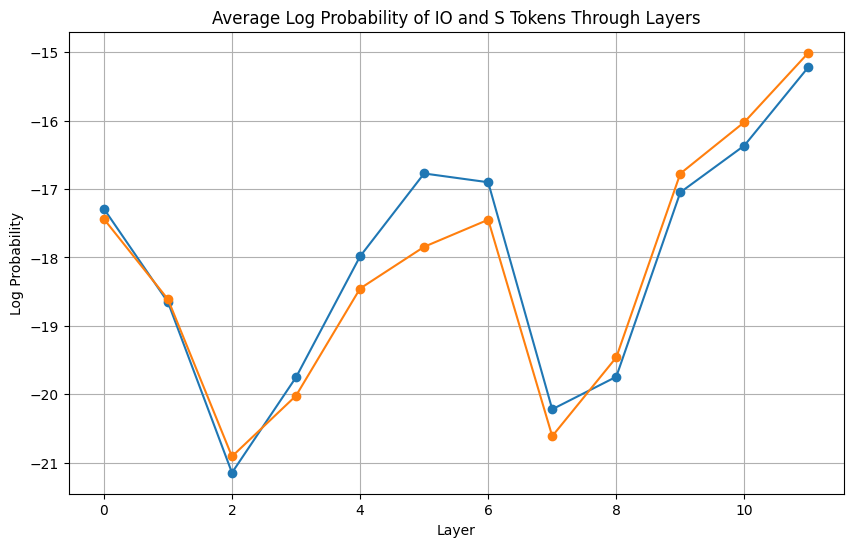

In [10]:
import matplotlib.pyplot as plt

use_logprob = True

# Calculate the average log-probability of the IO token for each layer
if use_logprob:
    avg_io_prob = df.xs('io_logprob', level='Metric', axis=1).mean()
    avg_s_prob = df.xs('s_logprob', level='Metric', axis=1).mean()
else:
    # take exp of logprobs
    avg_io_prob = df.xs('io_logprob', level='Metric', axis=1).apply(np.exp).mean()
    avg_s_prob = df.xs('s_logprob', level='Metric', axis=1).apply(np.exp).mean()
    
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(avg_io_prob.index, avg_io_prob.values, marker='o', label='IO')
plt.plot(avg_s_prob.index, avg_s_prob.values, marker='o', label='S')
plt.xlabel('Layer')
if use_logprob:
    plt.ylabel('Log Probability')
    plt.title('Average Log Probability of IO and S Tokens Through Layers')
else:
    plt.ylabel('Probability')
    plt.title('Average Probability of IO and S Tokens Through Layers')
plt.grid(True)
plt.show()

### Attack 2: plot average or median position of IO token against layer
This tells you approximately what top-"k" you need to find the IO token in the correct layer

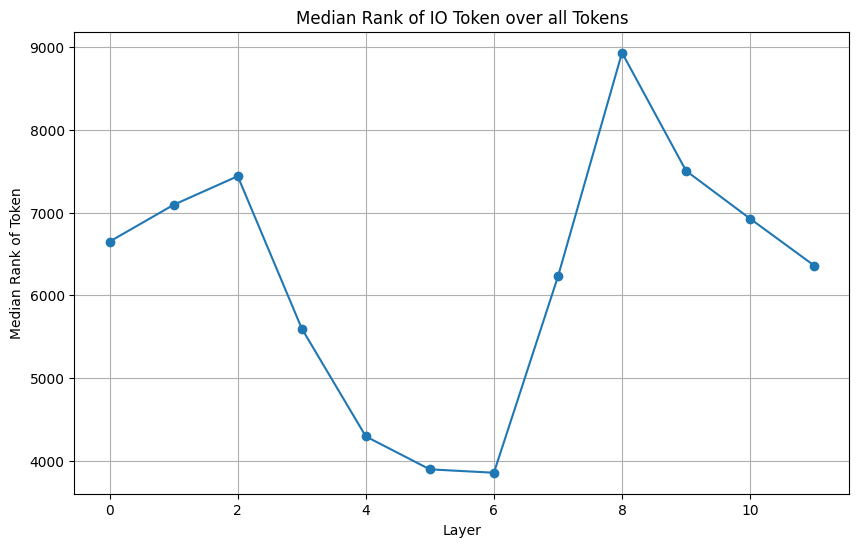

In [11]:
# Plot median position of IO token against layer

# Calculate the median position of the IO token for each layer
median_io_pos = df.xs('io_pos', level='Metric', axis=1).median()

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(median_io_pos.index, median_io_pos.values, marker='o')
plt.xlabel('Layer')
plt.ylabel('Median Rank of Token')
plt.title('Median Rank of IO Token over all Tokens')
plt.grid(True)
plt.show()

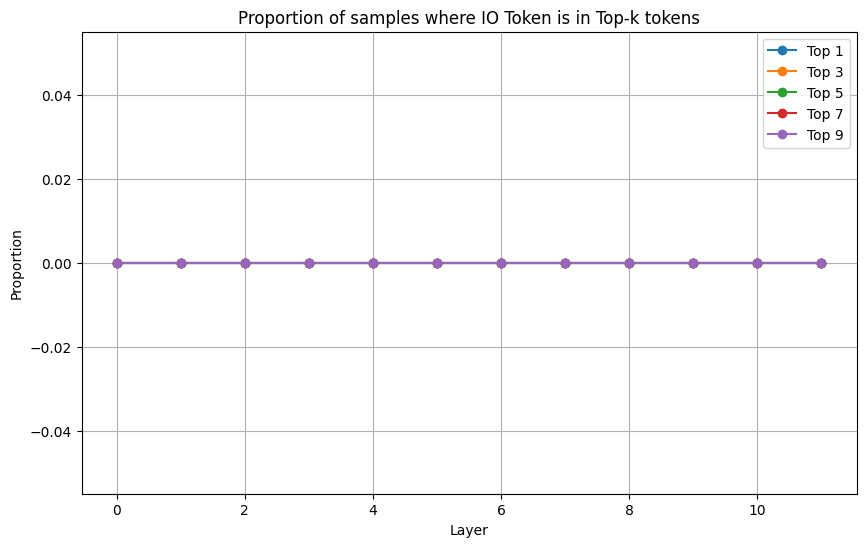

In [12]:
# Given top-k, what proportion of the time is the IO token in the top-k?

def get_top_k_accuracy(df, k):
    # Calculate the proportion of the time the IO token is in the top-k
    top_k = df.xs('io_pos', level='Metric', axis=1) <= k
    top_k_accuracy = top_k.mean()
    return top_k_accuracy

# Create the plot
plt.figure(figsize=(10, 6))
for k in range(1, 11, 2):
    top_k_accuracy = get_top_k_accuracy(df, k)
    plt.plot(top_k_accuracy.index, top_k_accuracy.values, marker='o', label=f'Top {k}')

plt.xlabel('Layer')
plt.ylabel('Proportion')
plt.title('Proportion of samples where IO Token is in Top-k tokens')
plt.grid(True)
plt.legend()
plt.show()

### Attack 3: Probability Delta
Deleted answer may quickly rise and fall in probability, so rank order differences in the probs of each token between successive layers

In [13]:
use_logprob = True
vocab_size = tokenizer.vocab_size
use_abs = True

# Initialize an empty DataFrame with MultiIndex for 11 layers
columns = pd.MultiIndex.from_product([range(11), ['io_diff_rank']], names=['Layer', 'Metric'])
df_diff = pd.DataFrame(columns=columns)

for point_idx in tqdm(range(len(outputs[0]))):
    io_token = tokenizer(" "+batch['IO'][point_idx])['input_ids'][-1]
    data = {}  # This will hold the data for this point_idx
    probs_tensor = torch.zeros(12, tokenizer.vocab_size)
    for decode_layer in range(12):
        with torch.no_grad():
            logits = get_logits(model, outputs[decode_layer][point_idx])[0, -1]
            logprobs = F.softmax(logits, dim=-1)
            if use_logprob:
                probs_tensor[decode_layer] = logprobs
            else:
                probs_tensor[decode_layer] = logprobs.exp()

    # probability of IO token should drop from layer n to n+1, so probs[n+1] - probs[n] should be negative, find the most negative or just abs
    if use_abs:
        diff = (probs_tensor[1:] - probs_tensor[:-1]).abs()  # shape (11, vocab_size)
    else:
        diff = probs_tensor[:-1] - probs_tensor[1:] # larger = higher drop

    # print(diff.shape)
    io_diffs = diff[:, io_token]
    for layer_diff_index in range(11):
        io_diff = io_diffs[layer_diff_index]
        io_diff_rank = (diff[layer_diff_index] >= io_diff).sum().item()
        # Add the metric to the data dictionary
        data[(layer_diff_index, 'io_diff_rank')] = io_diff_rank
    # Add the data for this point_idx to the DataFrame
    # df_diff = df_diff.append(pd.Series(data, name=point_idx))
    df_diff.loc[point_idx] = pd.Series(data, name=point_idx)

# Now df_diff holds the data for all point_idx and layers
display(df_diff)

100%|██████████| 64/64 [00:29<00:00,  2.16it/s]


Layer,0,1,2,3,4,5,6,7,8,9,10
Metric,io_diff_rank,io_diff_rank,io_diff_rank,io_diff_rank,io_diff_rank,io_diff_rank,io_diff_rank,io_diff_rank,io_diff_rank,io_diff_rank,io_diff_rank
0,8035,26734,16695,10855,26291,13786,21068,14687,16564,15408,21730
1,4108,4794,2481,3937,3553,3413,3255,6439,2920,5544,1422
2,4530,9822,12768,5316,7670,5944,5118,11909,4699,5548,13273
3,2334,1075,921,1950,2711,2173,1506,4938,8901,3032,3289
4,3717,13099,7878,4391,3292,2895,3988,10857,2021,2391,4490
...,...,...,...,...,...,...,...,...,...,...,...
59,14738,12223,7976,3675,2053,2075,2390,4727,2620,1515,1221
60,19766,16944,16623,12823,11709,7831,6679,17765,13942,14120,13790
61,13765,10178,1897,3963,5994,6696,7935,4706,1239,1201,1235


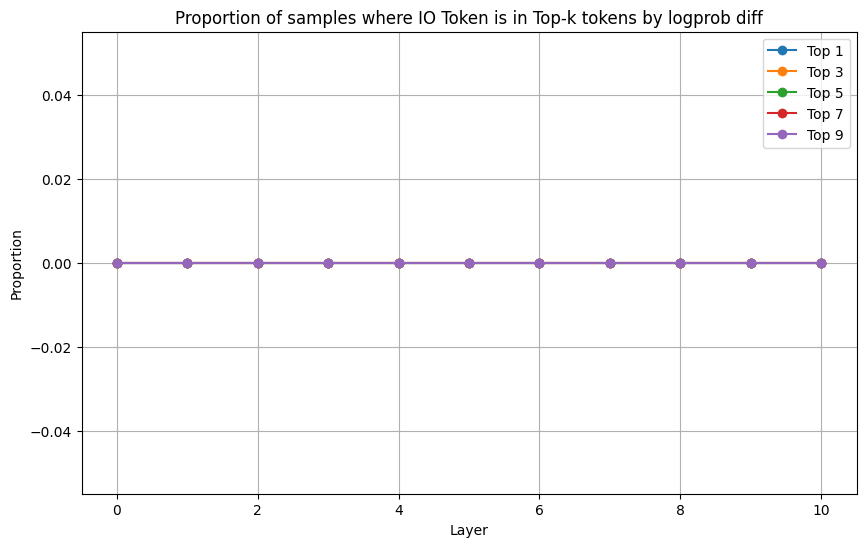

In [14]:
# Given top-k, what proportion of the time is the IO token in the top-k for df_diff?

def get_top_k_accuracy(df, k):
    # Calculate the proportion of the time the IO token is in the top-k
    top_k = df.xs('io_diff_rank', level='Metric', axis=1) <= k
    top_k_accuracy = top_k.mean()
    return top_k_accuracy

# Create the plot
plt.figure(figsize=(10, 6))
for k in range(1, 11, 2):
    top_k_accuracy = get_top_k_accuracy(df_diff, k)
    plt.plot(top_k_accuracy.index, top_k_accuracy.values, marker='o', label=f'Top {k}')


plt.xlabel('Layer')
plt.ylabel('Proportion')
plt.title('Proportion of samples where IO Token is in Top-k tokens by logprob diff')
plt.grid(True)
plt.legend()
plt.show()


### Get attack performances
As per the paper, get the proportion of times the IO token is in the candidate set, with the candidate set being constructed from either topk logprobs or topk diffs. As input, use L (which layers to analyze) and k, with a bound of |L|*k <= B (budget).

In [ ]:
# budget = 20
# lk_combos = [(1, 20), (2, 10), (4, 5), (5, 4), (10, 2)] # first number is num layers to look at, second number is num tokens to look at

# check all layers, check top 10 tokens
